# 🐍.4 Regression in Python Part 2

*With: Nate & Tyler*


What have we accomplished so far?
>We've developed a linear regression model to predict University GPA from SAT scores. We know this is imperfect and we developed a measure, `loss_function`, to determine the accuracy of prediction. 

*So what's next?* <br>
>Let's identify ways to improve our prediction!

In [24]:
# Let's import some of the modules we'll need
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
sys.path.append('../../custom')

from db_utils import get_connection, validate_connection, get_data
pd.options.display.float_format = '{:,.2f}'.format

# Import the statsmodels module and associated information we'll need to perform this analysis
import statsmodels.api as sm

# Load data from CSV that we'll be using
data = pd.read_csv('sat_data.csv')
data['Total_SAT'] = data['math_SAT'] + data['verb_SAT']

# Motivation

If we remember in part 1, we were aiming to decide on admissions results to FlexportUniversity and determing a way to predict the highest achieving students from information we had at the time. 

We were able to predict college GPA (and thus select our top students) via SAT scores. But, that's not the only information we have about these high school students. We'll aim to increase the indepentent variables we use in our prediction to improve the accuracy of our predictions.

Recall we defined our equation for linear regresion as
<br><br>
\begin{equation}
Y_i = f(X) = \beta_0 + \beta_1 X_i + \epsilon_i
\end{equation}
<br><br>

We can add additional $\beta_{i}$ values as additional independent variables in our equation and continue to minimize our error.

> What other variables might be useful in predicting college GPA?

In [3]:
# Let's look at our data and think about what fields might allow us to get a better prediction
data.head()

,high_GPA,math_SAT,verb_SAT,comp_GPA,univ_GPA,highschool,Total_SAT
0,2.36,559,536,2.03,2.24,School B,1095
1,2.48,574,602,2.07,2.24,School C,1176
2,2.24,554,542,2.07,2.34,School B,1096
3,2.52,554,507,2.09,2.27,School B,1061
4,2.19,562,507,2.10,2.21,School C,1069


## Let's Brainstorm some ideas of how this might work anecdotally

Our prediction in our last model was based off only a single predictor variable -- let's graph the expected vs predicted values to get an idea of how accurate our model was.

## Let's Review the accuracy of our Univariate Model

In [9]:
# Going to define a function for plotting our test results
def display_model_fit(model: sm.OLS, title) -> None:


    fig = plt.figure()
    plt.scatter(model.model.endog, model.fittedvalues)
    fig.suptitle('%s : R2 = %.2f' %(title, model.rsquared))
    plt.xlabel('Actual %s' %model.model.endog_names)
    plt.ylabel('Predicted %s' %model.model.endog_names)
    plt.plot(np.arange(2,4.2,.2), np.arange(2,4.2,.2), color='red', label="Perfect Prediction")
    fig.legend()
    plt.show()
    return

In [10]:
# Initialize a Univariate Linear Regression like in our last lesson
X_univariate = data.Total_SAT
X_univariate = sm.add_constant(X_univariate)
Y = data.univ_GPA
univariate_model = sm.OLS(Y, X_univariate).fit()

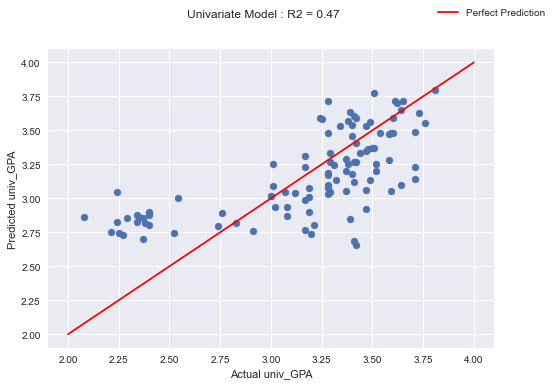

In [11]:
display_model_fit(univariate_model, 'Univariate Model')

## Let's build a multivariate model

- Build our X dataset so that it contains multiple independent variables
- Make sure to add a constant and fit the model as above

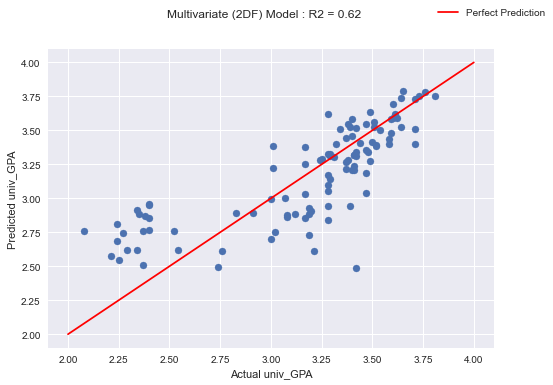

In [14]:
X_mv = data[['high_GPA', 'Total_SAT']]
X_mv = sm.add_constant(X_mv)
mv_model = sm.OLS(Y, X_mv).fit()
display_model_fit(mv_model, 'Multivariate (2DF) Model')

### What Kind of Results do we Get?
- Expect that high school SAT matters less once we add in GPA.
- Exploit the lack of correlation between SAT & GPA. Which is better/worse.
- Understand how we control for X when making this calculation

*Tyler to add some discussion here!*

## What other information may play a role in high school students?

- Aim to lead discussion towards schools, different standards across schools


## So how can we build a regression against non-numeric variables?

Dummy Variables!

In [25]:
# We'll use a pandas function to create a new df of dummies from our highschool column, then join it
dummies = pd.get_dummies(data.highschool)
dummies.columns = dummies.columns.str.replace(' ', '_')
data = data.join(dummies)

In [27]:
data.head()

,high_GPA,math_SAT,verb_SAT,comp_GPA,univ_GPA,highschool,Total_SAT,School_A,School_B,School_C
0,2.36,559,536,2.03,2.24,School B,1095,0,1,0
1,2.48,574,602,2.07,2.24,School C,1176,0,0,1
2,2.24,554,542,2.07,2.34,School B,1096,0,1,0
3,2.52,554,507,2.09,2.27,School B,1061,0,1,0
4,2.19,562,507,2.10,2.21,School C,1069,0,0,1


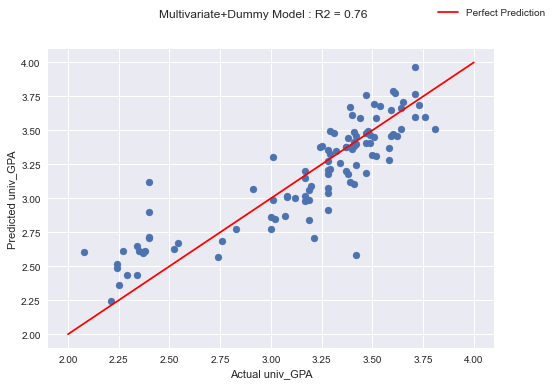

In [33]:
# Now that we have dummy variables we can simply add them to the regression and update our fit
X_dummy = data[['high_GPA', 'Total_SAT', 'School_A', 'School_B', 'School_C']]
X_dummy = sm.add_constant(X_dummy)

dummy_model = sm.OLS(Y, X_dummy).fit()
display_model_fit(dummy_model, 'Multivariate+Dummy Model')

## Great!
### We've improved our Rsquared from 0.47 to 0.76

But we need to discuss how we got here. We've introduced additional variables, which means additional degress of freedom. While in cases this may allow us to describe more of the variance in our data, it may also lead to things like overfitting if we're not validating the logic of our model.

*More Tyler Discussion!*


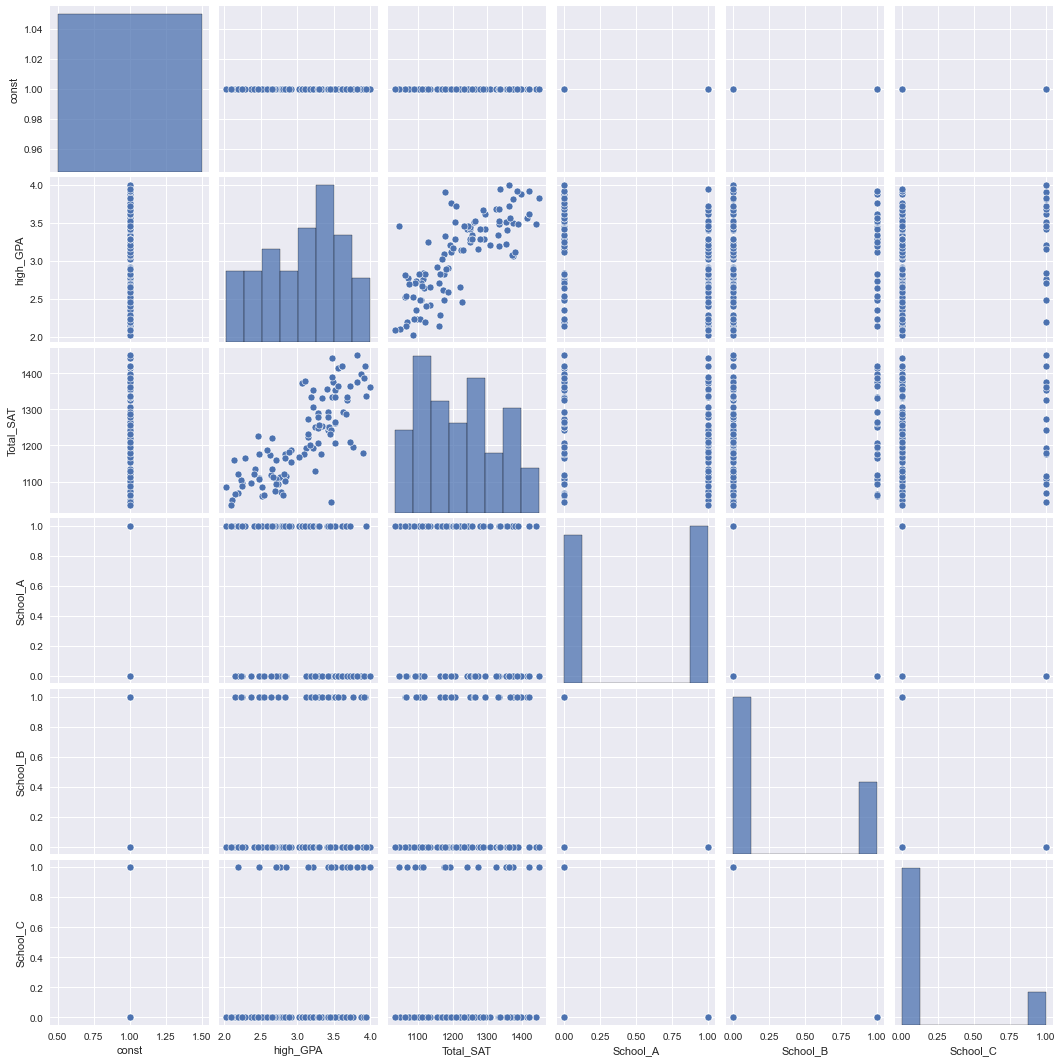

In [34]:
# Let's use a pre-made tool to identify interactions between variables
import seaborn as sns
sns.pairplot(X_dummy)

## Let's think about interactions between schools and scores
<br>
We've discussed that we feel some schools may have higher SAT/GPA scores, but in our model with dummy variables the anecdotal calculation doesn't make much sense. If you review the model you'll see our equation comes out to:
<br>
<br>
\begin{equation}
univGPA = \beta_0 + \beta_1 totalSAT + \beta_2 highGPA + \beta_3 School_A + \beta_4 School_B + \beta_5 School_C
\end{equation}
<br>
In the equation above we're giving specific weights to begin from a certain school, but this doesn't account for what we've described anecdotally. This can be interpreted as students from School A will be starting from a higher baseline GPA in college than students in School C. We described this as certain schools might have different ways of scoring their student's GPAs, aka some are harder than others. We can solve this via interaction variables. We want the equation to look like the following equation:
<br>
<br>
\begin{equation}
univGPA = \beta_0 + \beta_1 totalSAT + \beta_2 highGPA School_A + \beta_3 highGPA School_B + \beta_4 highGPA School_C
\end{equation}

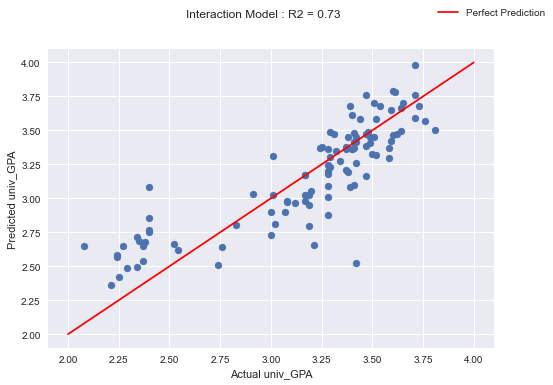

In [38]:
# First we'll initialize our interaction variables & add them to the model
data['high_GPA_x_A'] = data['high_GPA'] * data['School_A']
data['high_GPA_x_B'] = data['high_GPA'] * data['School_B']
data['high_GPA_x_C'] = data['high_GPA'] * data['School_C']
X_interact = data[['Total_SAT', 'high_GPA_x_A', 'high_GPA_x_B', 'high_GPA_x_C']]
X_interact = sm.add_constant(X_interact)

# Next we'll run the model and see what improvement it gives us.
interaction_model = sm.OLS(Y, X_interact).fit()
display_model_fit(interaction_model, 'Interaction Model')

## Space for a Tyler Treatise on Degrees of Freedom, modeling practices etc.